In [9]:
import numpy as np
from numpy import savetxt, loadtxt
import matplotlib.pyplot as plt

In [10]:
data_size = 200
noise = 1 # the higher the noisier

# we now open the file input_vectors.txt so that the vhd code can process it
f = open("input.txt", "w")

input_sig = []

for i in range(data_size):
    sig = 60*(np.sin(i/10)+ noise)
    noise = -noise
    f.write('%d\n' % sig.astype(int)) # we write it as an int
    input_sig.append(sig.astype(int)) # we write it as an int

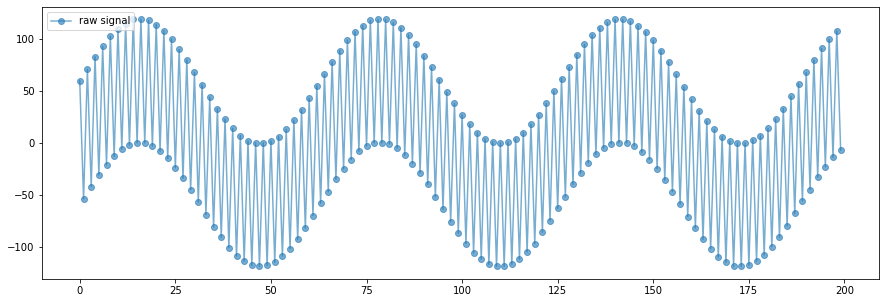

In [11]:
t = np.arange(len(input_sig)) # array for the x coordinate, just for displaying

plt.figure(figsize=(15, 5))

plt.plot(t, input_sig, '-o',alpha=.6,label='raw signal')
plt.legend(loc="upper left")

In [12]:
# After being computed on the actual FPGA

In [13]:
# we save the result obtained using the testbench in a array named tb
fpga = [0,0,0,0,0,2,-2,0,0,0,0,0,0,0,0,4,-2,8,-2,8,-2,8,-2,8,-2,8,-2,8,-2,8,-2,9,-2,9,-2,9,-2,8,-2,1,-2,1,-2,1,-2,1,-2,1,-8,-8,-8,-8,-8,-8,-8,-9,-10,-10,-10,-10,-10,-10,-10,-10,-10,-7,-4,-3,-3,-3,-3,-3,-3,-3,-3,1,-2,6,-2,6,-2,6,-2,6,-2,6,-2,6,-2,9,-2,9,-2,9,-2,9,-2,9,-2,4,-2,4,-2,4,-2,4,-2,3,-6,-6,-6,-6,-6,-6,-6,-8,-10,-10,-10,-10,-10,-10,-10,-10,-10,-8,-6,-6,-6,-6,-6,-6,-6,-6,-5,-1,3,-2,4,-2,4,-2,4,-2,4,-2,4,-2,7,-2,9,-2,9,46,-32,9,-2,9,-2,8,-2,6,-2,6,-2,6,-2,6,-2,6,-2,-3,-3,-3,-3,-4,-10,-10,-10,-10,-10,-10,-10,-10,-10,-9,-8,-8,-8,-8,-8,-8,-8,-8,-8,-4,1,-2,1,-2]

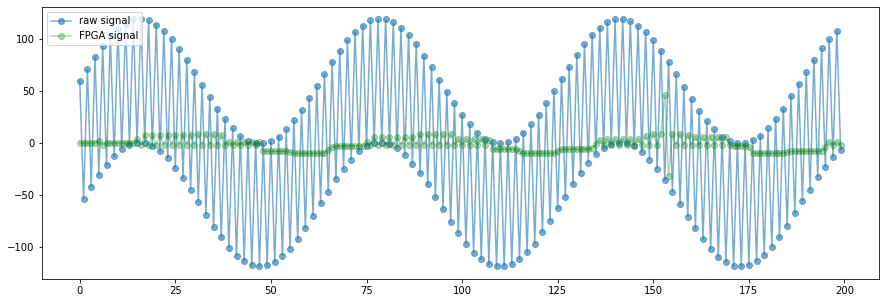

In [14]:
plt.figure(figsize=(15, 5))

plt.plot(t, input_sig, '-o',alpha=.6,label='raw signal')
plt.plot(t, fpga, '-o', color='g',alpha=.3,label='FPGA signal')
#plt.title("")
#plt.xlim(0,130) #just for the latex report
plt.legend(loc="upper left")